In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import PyDataset, load_img, img_to_array
from tqdm.keras import TqdmCallback
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import albumentations as A
import sys
import time
from collections import defaultdict

Segmentation Models: using `tf.keras` framework.


In [2]:
# Ajouter le chemin vers "src" dans sys.path
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from models.unet_models import build_unet_mini, build_vgg16_unet, build_mobilenet_fpn
from preprocessing.preprocessing import preprocess_mask, preprocess_image_func, color_to_category_id, category_name_to_id, category_id_to_colors
from predictions.predictions import predict_mask

# Objectif

L'objectif de ce projet est de développer un modèle de segmentation pour analyser les images provenant des caméras d'un véhicule autonome.  
En s'appuyant sur le dataset **Cityscapes**, le modèle devra classifier chaque pixel d'une image en une des **8 catégories principales** (comme "route", "piéton", "véhicule", etc.).  
Cette segmentation permettra au véhicule de mieux comprendre son environnement visuel et de faciliter la prise de décision en temps réel.

# Présentation du jeu de données

Nous disposons du dataset **Cityscapes** qui contient un ensemble d'images capturées par une caméra d'un véhicule autonome. Pour chaque image, nous disposons également de son **masque** qui présente les caractéristiques suivantes:  
* Le masque est une image de même dimension que l'image originale
* Chaque pixel du masque est associé à une classe ("route", "piéton", "véhicule", etc.)

L'ensemble des images et des masques sont regroupés par ville dans un même répertoire.

# Prétraitement des données

Avant de commencer l'entrainement d'un modèle, nous devons associer chaque couleur d'un masque à une catégorie. Pour cela, nous pouvons récupérer le mapping officiel disponible dans le [repository Github officiel](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py).  
Les fonctions de preprocessing utilisées dans ce notebook sont disponibles dans le module python ``preprocessing``.

Construisons la liste des images et masques nécessaires à la construction des datasets.

In [3]:
def get_images_and_masks(image_folder, mask_folder):

  def collect_images_and_masks(image_folder, mask_folder, image_files, mask_files):
    for image_file_name in os.listdir(image_folder):
      image_file_path = os.path.join(image_folder, image_file_name)
      if os.path.isdir(image_file_path):
          mask_file_path = os.path.join(mask_folder, image_file_name)
          collect_images_and_masks(image_file_path, mask_file_path, image_files, mask_files)
      elif image_file_name.endswith("_leftImg8bit.png"):
        mask_file_path = os.path.join(mask_folder, image_file_name.replace("_leftImg8bit.png", "_gtFine_color.png"))
        image_files.append(image_file_path)
        mask_files.append(mask_file_path)

  image_files, mask_files = [], []
  collect_images_and_masks(image_folder, mask_folder, image_files, mask_files)
  return image_files, mask_files


In [4]:
images_train, masks_train = get_images_and_masks("../data/source/original/train", "../data/source/masques/train")
images_val, masks_val = get_images_and_masks("../data/source/original/val", "../data/source/masques/val")

Le jeu de test disponible en téléchargement sur le site officiel de Cityscapes est corrompu (tous les masques sont des images noires).  
Pour contourner ce problème, nous allons réserver 15% du jeu d'entrainement pour les tests.

In [5]:
images_train, images_test, masks_train, masks_test = train_test_split(images_train, masks_train, train_size=0.85, random_state=42)

Visualisons les tailles respectives de nos datasets:

In [6]:
images_count = len(images_train) + len(images_val) + len(images_test)
print(f"images_train : {len(images_train)} images ({len(images_train) / images_count * 100: 0.2f}%)")
print(f"images_val : {len(images_val)} images ({len(images_val) / images_count * 100: 0.2f}%)")
print(f"images_test : {len(images_test)} images ({len(images_test) / images_count * 100: 0.2f}%)")

images_train : 2528 images ( 72.75%)
images_val : 500 images ( 14.39%)
images_test : 447 images ( 12.86%)


Lors de l'entrainement des modèles, la quantité d'images à charger peut très rapidement saturer la mémoire. Pour contouner ce problème, nous pouvons utiliser un **Data Generator** dont le rôle est de charger les images et les masques par lots (appelés batchs).

In [7]:
class SegmentationDataGenerator(PyDataset):

    def __init__(self, image_paths, mask_paths, batch_size, image_width, image_height, num_classes, preprocess_func):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_width = image_width
        self.image_height = image_height
        self.num_classes = num_classes
        self.preprocess_func = preprocess_func

    def __len__(self):
        return int(np.ceil(len(self.image_paths) // self.batch_size))

    def __getitem__(self, idx):
        batch_img = self.image_paths[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_mask = self.mask_paths[idx * self.batch_size: (idx + 1) * self.batch_size]

        target_size = (self.image_width, self.image_height)
        X = [self.preprocess_func(img_to_array(load_img(img_path, target_size=target_size))) for img_path in batch_img]
        y = [preprocess_mask(mask_path, target_size, self.num_classes) for mask_path in batch_mask]

        return np.array(X), np.array(y)

# Modélisation

Après avoir chargé et préparé les images et leurs masques associés, nous avons effectué les étapes nécessaires de prétraitement. En particulier, les images ont été redimensionnées à une taille de 512x512 pixels, ce qui permet d’assurer une uniformité dans les données d'entrée pour le modèle, tout en respectant les contraintes de mémoire et de calcul. Les masques associés ont également été redimensionnés pour correspondre à la taille des images.  

De plus, chaque masque a été converti en un tableau NumPy où chaque pixel est maintenant représenté sous forme de vecteur **one-hot**. Cela signifie que pour chaque pixel de l'image, nous avons un vecteur de longueur égale au nombre de classes (ici, 8 classes) où une seule valeur est activée (1) pour la classe correspondant au pixel, et les autres valeurs sont à zéro. Cette transformation est cruciale pour la segmentation sémantique, car elle permet au modèle de prédire de manière précise la classe de chaque pixel de l'image.  

Avec ces données prêtes, nous avons maintenant toutes les bases nécessaires pour construire le modèle de segmentation. Nous pouvons utiliser ces images et masques prétraités pour entraîner notre modèle, avec l'objectif de prédire la classe de chaque pixel des images de test.

Nous testerons 3 modèles de segmentation sur ce projet:
- **Unet Mini**: une architecture CNN légère et rapide adaptée aux tâches de segmentation
- **Unet VGG-16**: une architecture CNN avancée basée sur VGG-16
- **FPN Mobilenet**: une architecture CNN avancée basée sur Mobilnet

In [8]:
models = []

## 1. Unet Mini

### 1.1 Présentation

Le modèle **UNet Mini** est une architecture de segmentation sémantique simple et efficace, adaptée aux tâches nécessitant une segmentation pixel-par-pixel rapide avec des ressources limitées. Inspiré de la version originale de UNet, ce modèle utilise une approche en encodeur-décodeur symétrique avec des connexions directes ("skip connections") entre les couches correspondantes des chemins d'encodage et de décodage.

L'encodeur réduit progressivement la résolution de l'image tout en extrayant des caractéristiques globales importantes. Le décodeur, quant à lui, reconstruit l'image segmentée en combinant les caractéristiques globales extraites avec les détails locaux préservés grâce aux skip connections. Cela permet de maintenir une bonne précision sur les frontières des objets tout en simplifiant le calcul.

Contrairement à des modèles plus complexes comme Unet VGG16, UNet Mini est conçu pour des scénarios où une segmentation rapide et légère est requise, avec des performances décentes sur des ensembles de données moins variés ou de plus petite taille. Cette architecture est particulièrement utile pour des applications nécessitant une segmentation en temps réel ou sur des dispositifs ayant des contraintes de mémoire et de calcul.

### 1.2 Construction du modèle

In [9]:
num_classes = len(category_name_to_id)
img_height = 256
img_width = 256
input_shape = (img_width, img_height, 3)

unet_mini = build_unet_mini(input_shape, num_classes)
models.append(unet_mini)

Affichons les détails du modèle Unet Mini:

In [10]:
unet_mini.summary()

Model: "Unet_mini"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 256, 256, 16)      │              64 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 256, 256, 16)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256, 256, 16)      │              64 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 256, 256, 16)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 16)      │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128, 128, 32)      │             128 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 128, 128, 32)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 128, 128, 32)      │             128 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 128, 128, 32)      │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 32)        │               0 │ activation_3[0][0]         │
│ (MaxPooling2D)                │                           │               

 Total params: 599,480 (2.29 MB)

 Trainable params: 597,688 (2.28 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 2. Unet VGG-16

### 2.1 Présentation

Le modèle **UNet** basé sur **VGG16** est une architecture de segmentation sémantique particulièrement réputée pour sa simplicité et son efficacité, notamment dans des tâches où la précision des contours et des zones segmentées est cruciale, comme la segmentation médicale, la segmentation d’images satellitaires ou les tâches industrielles.

L'architecture **UNet** repose sur une structure en forme de "U", où les caractéristiques extraites par un encodeur sont progressivement combinées avec les détails locaux restaurés par un décodeur. Cette approche permet de conserver des informations de bas niveau (comme les contours et les textures fines) tout en exploitant des informations de haut niveau pour une compréhension globale de l'image.

Dans notre version du modèle, nous utilisons **VGG16** comme backbone, un réseau convolutif bien établi et pré-entraîné sur **ImageNet**, reconnu pour ses performances robustes et sa capacité à extraire des caractéristiques visuelles importantes. Ce backbone constitue l’encodeur du modèle, et ses couches convolutives extraient des informations à différentes échelles tout en maintenant une bonne généralisation grâce à des poids pré-entraînés.

Une des forces majeures de ce modèle réside dans l'utilisation de **connexions skip** entre l’encodeur (VGG16) et le décodeur. Ces connexions permettent de transmettre directement des caractéristiques de bas niveau de l'encodeur vers les couches correspondantes du décodeur, préservant ainsi des détails cruciaux tout au long du processus de reconstruction. Cela garantit que le modèle peut générer des masques précis, en délimitant clairement les contours des objets dans les images.

Le modèle UNet avec VGG16 est particulièrement adapté aux tâches nécessitant une précision fine et une segmentation robuste des objets, notamment lorsque les tailles des objets varient considérablement dans l'image. Grâce à l'utilisation d’un décodeur qui restaure la résolution spatiale d’origine, le modèle est capable de produire des masques segmentés avec une haute fidélité à l'image d'entrée.

### 2.2 Construction du modèle

In [11]:
unet_vgg16 = build_vgg16_unet(input_shape, num_classes)
models.append(unet_vgg16)

Affichons les détails du modèle Unet VGG-16:

In [12]:
unet_vgg16.summary()

Model: "VGG16_UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 256, 256, 64)      │           1,792 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 256, 256, 64)      │          36,928 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 128, 128, 64)      │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 128, 128, 128)     │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 128, 128, 128)     │         147,584 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 64, 64, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv1 (Conv2D)         │ (None, 64, 64, 256)       │         295,168 │ block2_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv2 (Conv2D)         │ (None, 64, 64, 256)       │         590,080 │ block3_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv3 (Conv2D)         │ (None, 64, 64, 256)       │         590,080 │ block3_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_pool (MaxPooling2D)    │ (None, 32, 32, 256)       │               0 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv1 (Conv2D)         │ (None, 32, 32, 512)       │       1,180,160 │ block3_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv2 (Conv2D)         │ (None, 32, 32, 512)       │       2,359,808 │ block4_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv3 (Conv2D)         │ (None, 32, 32, 512)       │       2,359,808 │ block4_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_pool (MaxPooling2D)    │ (None, 16, 16, 512)       │               0 │ block4_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv1 (Conv2D)         │ (None, 16, 16, 512)       │       2,359,808 │ block4_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv2 (Conv2D)         │ (None, 16, 16, 512)       │       2,359,808 │ block5_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,753,288 (90.61 MB)

 Trainable params: 23,749,256 (90.60 MB)

 Non-trainable params: 4,032 (15.75 KB)

## 3. FPN Mobilenet

### 3.1 Présentation

Le modèle **FPN** (Feature Pyramid Network) basé sur **MobileNet** est une architecture avancée de segmentation sémantique, optimisée pour une efficacité computationnelle tout en offrant une excellente précision dans l'extraction de caractéristiques multi-échelles. Ce modèle combine la puissance du **FPN**, conçu pour capturer des informations à différentes résolutions, avec la légèreté et l'efficacité de **MobileNet**, un réseau convolutif réputé pour ses performances sur des dispositifs à ressources limitées.

L'architecture **FPN** repose sur une approche de pyramide de caractéristiques qui permet d'extraire des informations à plusieurs niveaux de granularité. Contrairement aux architectures classiques qui exploitent uniquement les caractéristiques des couches profondes, FPN fusionne les informations issues des couches de différentes résolutions, garantissant ainsi une meilleure détection des objets de toutes tailles et une segmentation plus précise.

Dans cette implémentation, **MobileNet** est utilisé comme **backbone**, jouant le rôle d’encodeur. MobileNet est un modèle optimisé pour l'efficacité, conçu avec des convolutions séparables en profondeur, ce qui réduit considérablement le nombre de paramètres et la complexité computationnelle sans sacrifier la qualité des caractéristiques extraites. Ce choix de backbone rend le modèle idéal pour des applications en temps réel, notamment sur des appareils mobiles, embarqués ou des systèmes avec des contraintes de calcul.

L'un des atouts majeurs du **FPN avec MobileNet** est sa capacité à **équilibrer précision et rapidité**. En exploitant les connexions ascendantes et descendantes du FPN, il permet une segmentation plus fine des structures tout en assurant une **généralisation robuste** face aux variations de taille et de contexte des objets dans l'image. Cette caractéristique est particulièrement utile dans des applications telles que la segmentation d’images médicales, l’analyse d’images satellites, ou encore la vision embarquée dans des véhicules autonomes et des drones.

Grâce à cette combinaison, le modèle **FPN-MobileNet** constitue une solution performante pour des tâches de segmentation sémantique nécessitant à la fois efficacité et précision, tout en restant accessible aux environnements à faible puissance de calcul.

### 3.2 Construction du modèle

In [13]:
fpn_mobilenet = build_mobilenet_fpn(input_shape, num_classes)
models.append(fpn_mobilenet)

C:\Users\brice\anaconda3\Lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Affichons les détails du modèle FPN Mobilenet:

In [14]:
fpn_mobilenet.summary()

Model: "Mobilenet_FPN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 257, 257, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1 (Conv2D)                │ (None, 128, 128, 32)      │             864 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 128, 128, 32)      │             128 │ conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (ReLU)             │ (None, 128, 128, 32)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_dw_1 (DepthwiseConv2D)   │ (None, 128, 128, 32)      │             288 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_dw_1_bn                  │ (None, 128, 128, 32)      │             128 │ conv_dw_1[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_dw_1_relu (ReLU)         │ (None, 128, 128, 32)      │               0 │ conv_dw_1_bn[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_pw_1 (Conv2D)            │ (None, 128, 128, 64)      │           2,048 │ conv_dw_1_relu[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_pw_1_bn                  │ (None, 128, 128, 64)      │             256 │ conv_pw_1[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_pw_1_relu (ReLU)         │ (None, 128, 128, 64)      │               0 │ conv_pw_1_bn[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_pad_2 (ZeroPadding2D)    │ (None, 129, 129, 64)      │               0 │ conv_pw_1_relu[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_dw_2 (DepthwiseConv2D)   │ (None, 64, 64, 64)        │             576 │ conv_pad_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_dw_2_bn                  │ (None, 64, 64, 64)        │             256 │ conv_dw_2[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_dw_2_relu (ReLU)         │ (None, 64, 64, 64)        │               0 │ conv_dw_2_bn[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_pw_2 (Conv2D)            │ (None, 64, 64, 128)       │           8,19

 Total params: 6,111,176 (23.31 MB)

 Trainable params: 6,086,984 (23.22 MB)

 Non-trainable params: 24,192 (94.50 KB)

# 4. Entrainement des modèles


Avant de commencer l'entrainement, nous allons définir 3 callbacks:
- **ModelCheckpoint** : Cette callback enregistre les poids du modèle à chaque époque si celui-ci présente une amélioration sur la perte de validation ('``val_loss``'). Les poids sont sauvegardés dans le fichier model_{name}_best_weights.keras.


In [15]:
def buildModelCheckpoint(sModelName):
    return ModelCheckpoint(
        f"../weights/model_{sModelName}_best_weights.keras",
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )

- **EarlyStopping** : Cette callback arrête l'entraînement si la perte de validation ('val_loss') ne s'améliore plus après un certain nombre d'époques défini grâce au paramètre patience.

In [16]:
def buildEarlyStopping():
    return EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=5
    )

- **ReduceLROnPlateau** : Cette callback ajuste le taux d'apprentissage automatiquement lorsque la perte de validation ('``val_loss``') cesse de s'améliorer après une certain nombre d'époques défini grâce au paramètre ``patience``. Cela permet de donner au modèle plus d'opportunités pour sortir des minima locaux en réduisant graduellement le taux d'apprentissage, ce qui peut parfois conduire à de meilleures performances.

In [17]:
def buildReduceLROnPlateau():
    return ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=4,
        min_lr=1e-6
    )

Lançons la phase d'entrainement des modèles.

In [20]:
# Hyperparameters
epochs = 10
batch_size = 8

# Entrainement
model_results = {}
for model in models:
    sModel = model.name
    start = time.time()
    model_results[sModel] = {}
    print(f"Training the model {sModel}...")

    preprocess_func = preprocess_image_func(model)
    
    # Création des générateurs d'entraînement et de validation
    train_generator = SegmentationDataGenerator(images_train, masks_train, batch_size, img_width, img_height, num_classes, preprocess_func)
    val_generator = SegmentationDataGenerator(images_val, masks_val, batch_size, img_width, img_height, num_classes, preprocess_func)

    # Compilation du modèle avec la métrique configurée pour multi-classes
    model.compile(optimizer='Adam', loss=bce_jaccard_loss, metrics=[iou_score])

    # Entraînement du modèle avec les données de validation
    model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        epochs=epochs,
        callbacks=[
            TqdmCallback(verbose=1),
            buildModelCheckpoint(sModel),
            buildEarlyStopping(),
            buildReduceLROnPlateau()
        ]
    )
    training_time = time.time() - start
    model_results[sModel]["training time"] = training_time
    print(f"Model {sModel} trained in {training_time:.2f}s")

Training the model Unet_mini...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

C:\Users\brice\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.2934 - loss: 0.8923
Epoch 1: val_loss improved from inf to 1.24794, saving model to ../models/model_Unet_mini_best_weights.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 674s 2s/step - iou_score: 0.2938 - loss: 0.8918 - val_iou_score: 0.1846 - val_loss: 1.2479 - learning_rate: 0.0010
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10


C:\Users\brice\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
C:\Users\brice\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
C:\Users\brice\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: iou_score,loss
  current = self.get_monitor_value(logs)
C:\Users\brice\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: iou_s

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.5347 - loss: 0.5794
Epoch 3: val_loss improved from 1.24794 to 1.11104, saving model to ../models/model_Unet_mini_best_weights.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - iou_score: 0.5348 - loss: 0.5794 - val_iou_score: 0.3313 - val_loss: 1.1110 - learning_rate: 0.0010
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.5828 - loss: 0.5287
Epoch 5: val_loss improved from 1.11104 to 0.63874, saving model to ../models/model_Unet_mini_best_weights.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 599s 2s/step - iou_score: 0.5828 - loss: 0.5287 - val_iou_score: 0.5271 - val_loss: 0.6387 - learning_rate: 0.0010
Epoch 6/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.6230 - loss: 0.47

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.3350 - loss: 0.8552
Epoch 1: val_loss improved from inf to 0.95967, saving model to ../models/model_VGG16_UNet_best_weights.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 876s 3s/step - iou_score: 0.3353 - loss: 0.8547 - val_iou_score: 0.3256 - val_loss: 0.9597 - learning_rate: 0.0010
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.5659 - loss: 0.5508
Epoch 3: val_loss improved from 0.95967 to 0.60427, saving model to ../models/model_VGG16_UNet_best_weights.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 853s 3s/step - iou_score: 0.5660 - loss: 0.5507 - val_iou_score: 0.5348 - val_loss: 0.6043 - learning_rate: 0.0010
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.6196 - l

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - iou_score: 0.5546 - loss: 0.5679
Epoch 1: val_loss improved from inf to 0.49448, saving model to ../models/model_Mobilenet_FPN_best_weights.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 1148s 4s/step - iou_score: 0.5548 - loss: 0.5677 - val_iou_score: 0.6200 - val_loss: 0.4945 - learning_rate: 0.0010
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - iou_score: 0.6810 - loss: 0.4005
Epoch 3: val_loss did not improve from 0.49448
316/316 ━━━━━━━━━━━━━━━━━━━━ 1124s 4s/step - iou_score: 0.6811 - loss: 0.4005 - val_iou_score: 0.6310 - val_loss: 0.4963 - learning_rate: 0.0010
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - iou_score: 0.7133 - loss: 0.3608
Epoch 5: val_loss improved from 0.49448 to 0.41778

# 5. Evaluation des modèles

Nos modèles Unet Mini, Unet VGG16 et FPN Mobilenet sont maintenant entrainés, nous pouvons à présent les évaluer sur le jeu de test:

In [24]:
# Évaluation des modèles sur le jeu de test
for model in models:
    sModel = model.name
    print(f"Evaluating the model {sModel} on the test dataset")
    
    preprocess_func = preprocess_image_func(model)
    
    # Création des générateurs d'entraînement et de validation
    test_generator = SegmentationDataGenerator(images_test, masks_test, batch_size, img_width, img_height, num_classes, preprocess_func)
    
    loss, intersection_over_union = model.evaluate(test_generator)
    model_results[sModel]["Loss"] = loss
    model_results[sModel]["Intersection over union"] = intersection_over_union

Evaluating the model Unet_mini on the test dataset
55/55 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - iou_score: 0.6247 - loss: 0.4793
Evaluating the model VGG16_UNet on the test dataset
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - iou_score: 0.6385 - loss: 0.4719
Evaluating the model Mobilenet_FPN on the test dataset
55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - iou_score: 0.7158 - loss: 0.3622


In [18]:
##Uncomment the following lines to load models from weights
#for model in models:
#    model.load_weights(f"../weights/model_{model.name}_best_weights.keras")
#    model.compile(optimizer='Adam', loss=bce_jaccard_loss, metrics=[iou_score])

In [19]:
def build_eval_results_dataframe(model_results):
    """
    Constructs a pandas DataFrame from a dictionary containing evaluation results of multiple models.

    Parameters:
    -----------
    model_results : dict
        A dictionary where keys represent model names (or identifiers) and values are dictionaries
        containing evaluation metrics and their corresponding values.

        Example format:
        {
            "model_1": {"accuracy": 0.85, "loss": 0.35},
            "model_2": {"accuracy": 0.89, "loss": 0.28}
        }

    Returns:
    --------
    pd.DataFrame
        A pandas DataFrame where:
        - Rows correspond to the model names (keys of `model_results`).
        - Columns correspond to the evaluation metrics (keys of the nested dictionaries in `model_results`).
        - Values represent the metric values for each model.

        Example output:
                       accuracy   loss
        model_1       0.85       0.35
        model_2       0.89       0.28
    """
    data = defaultdict(list)
    for sModel, props in model_results.items():
        for sKey, val in props.items():
            data[sKey].append(val)
    return pd.DataFrame(data=data, index=list(model_results.keys()))

Affichons les différentes métriques d'évaluation pour les 3 modèles testés

In [26]:
df = build_eval_results_dataframe(model_results)
df

,training time,Loss,Intersection over union
Unet_mini,3079.274988,0.479822,0.623297
VGG16_UNet,4288.488049,0.471988,0.638763
Mobilenet_FPN,5636.772593,0.363237,0.716190


Pour tester la prédiction du modèle, nous allons lui soumettre un image du jeu de test et lui demander de retourner en sortie le masque prédit.  
Créons une fonction pour cela:

In [20]:
def plot_image_and_mask(model_name, image, true_mask, pred_mask):
    # Afficher l'image d'origine, le masque d'origine et le masque prédit
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f"Modèle {model_name}", fontsize=14)

    # Afficher l'image originale
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image Originale")
    plt.axis('off')

    # Afficher le masque orginal
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    plt.title("Masque réel")
    plt.axis('off')
    
    # Afficher le masque coloré
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title("Masque prédit")
    plt.axis('off')

    plt.show()

In [21]:
def plot_predictions_for_random_image(models, images_test, masks_test, target_size):
    image_idx = np.random.randint(len(images_test))
    image = load_img(images_test[image_idx], target_size=target_size)
    true_mask = load_img(masks_test[image_idx], target_size=target_size)
    image_array = img_to_array(image)
    
    for model in models:
        pred_mask = predict_mask(model, image_array, category_id_to_colors)
        plot_image_and_mask(model.name, image, true_mask, pred_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


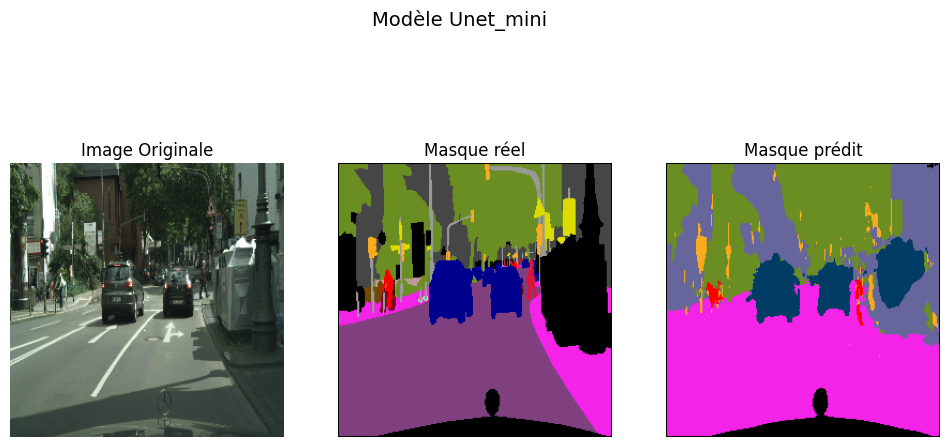

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


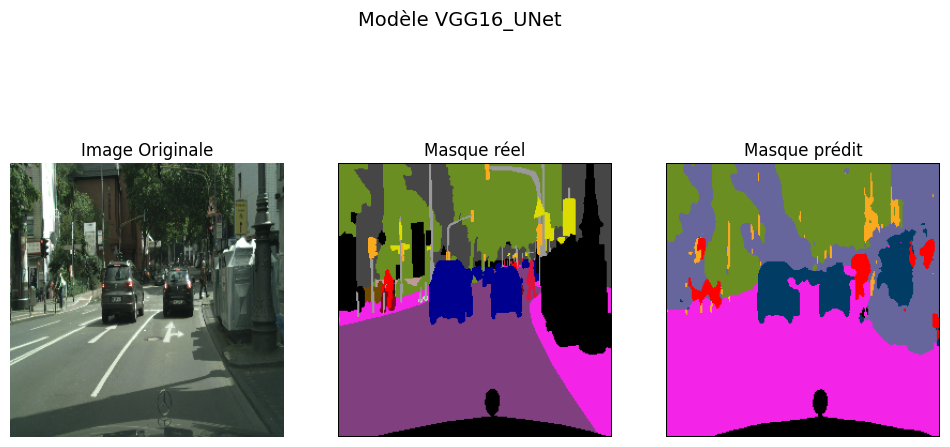

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


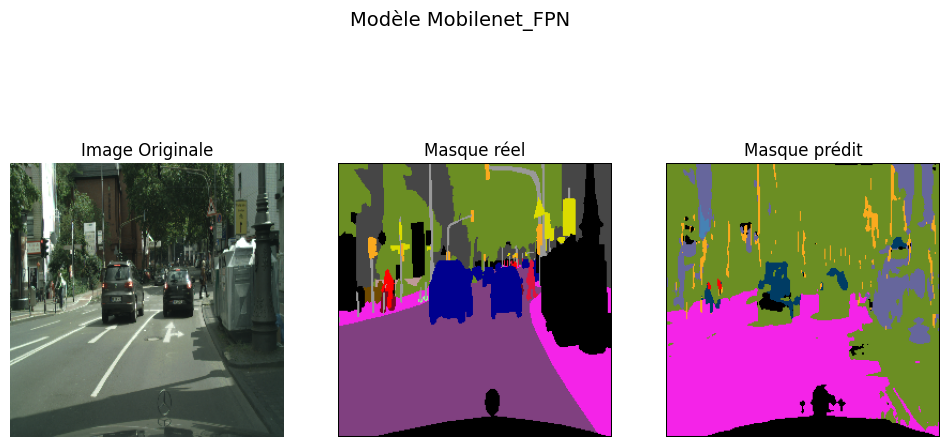

In [22]:
plot_predictions_for_random_image(models, images_test, masks_test, (img_width, img_height))

# 6. Data augmentation

L'idée de la **data augmentation** est d'appliquer des transformations aléatoires sur les images d'entrée pour augmenter la diversité des données utilisées lors de l'entraînement d'un modèle.
Les transformations incluent par exemple :
- Flip horizontal aléatoire.
- Rotation aléatoire jusqu'à ±10% de l'image.
- Zoom aléatoire jusqu'à 20%.

## 6.1 Applications des transformations

Créons d'abord un nouveau data generator pour appliquer des transformations à une image et vérifier si l'image augmentée est réaliste:

In [32]:
class SegmentationDataGeneratorWithAugmentation(SegmentationDataGenerator):
    def __init__(self, image_paths, mask_paths, batch_size, image_width, image_height, num_classes, preprocess_func, training=False):
        """
        Initialise un générateur de données avec augmentation optionnelle.
        
        Args:
            image_paths (list): Liste des chemins des images.
            mask_paths (list): Liste des chemins des masques.
            batch_size (int): Taille du batch.
            image_width (int): Largeur des images.
            image_height (int): Hauteur des images.
            num_classes (int): Nombre de classes pour la segmentation.
            preprocess_func (callable): Fonction de pré-traitement des images.
            augment (bool): Active ou non l'augmentation de données.
        """
        super().__init__(image_paths, mask_paths, batch_size, image_width, image_height, num_classes, preprocess_func)
        self.training = training

        # Définition des transformations avec Albumentations
        self.augmentation_pipeline = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=20, p=0.5),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3)
        ])
    
    def __getitem__(self, idx):
        """
        Récupère un batch d'images et de masques, avec option d'augmentation.
        """
        X, y = super().__getitem__(idx)  # Récupère les données du parent
        
        if self.training:
            X_aug, y_aug = [], []
            for img, mask in zip(X, y):
                augmented = self.augmentation_pipeline(image=img, mask=mask)
                X_aug.append(augmented["image"])
                y_aug.append(augmented["mask"])
            return np.array(X_aug), np.array(y_aug)
        
        return X, y  # Si pas d'augmentation, retourne les données d'origine

In [44]:
def plot_image_and_augmented_image(train_generator, image_path, mask_path):
    image = img_to_array(load_img(image_path)) / 255.0
    mask = img_to_array(load_img(mask_path, color_mode="grayscale"))

    # Appliquer l'augmentation
    augmented = train_generator.augmentation_pipeline(image=image, mask=mask)
    
    # Afficher l'image d'origine et son image augmentée
    fig = plt.figure(figsize=(12, 6))

    # Afficher l'image originale
    plt.subplot(1, 3, 1)
    plt.imshow(image)  # Remplacez par votre image réelle si nécessaire
    plt.title("Image originale")
    plt.axis('off')

    # Afficher l'image augmentée
    plt.subplot(1, 3, 2)
    plt.imshow(augmented["image"])
    plt.title("Image augmentée")
    plt.axis('off')

    # Afficher le masque augmentée
    plt.subplot(1, 3, 3)
    plt.imshow(augmented["mask"])
    plt.title("Masque augmenté")
    plt.axis('off')
    
    plt.show()

C:\Users\brice\anaconda3\Lib\site-packages\albumentations\core\validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\brice\AppData\Local\Temp\ipykernel_18324\705636211.py:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


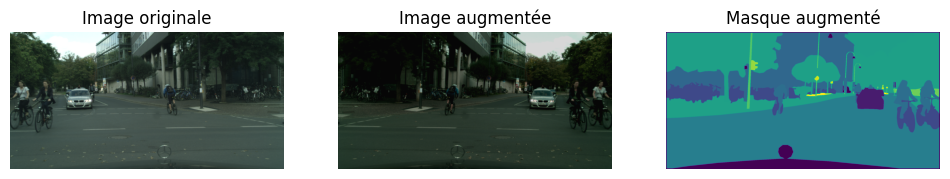

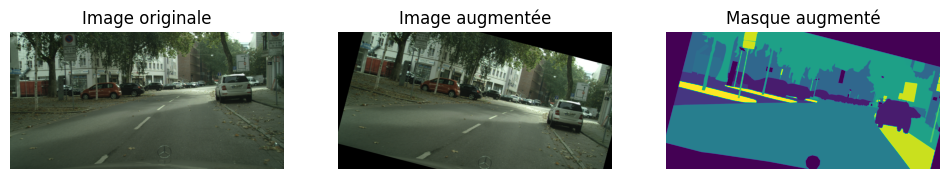

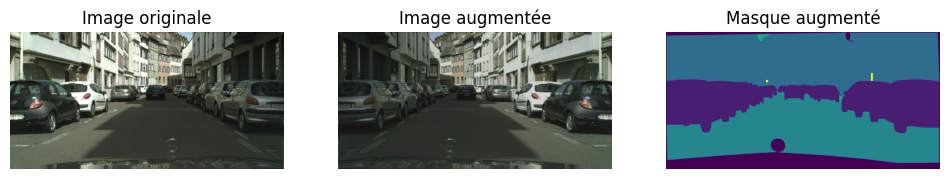

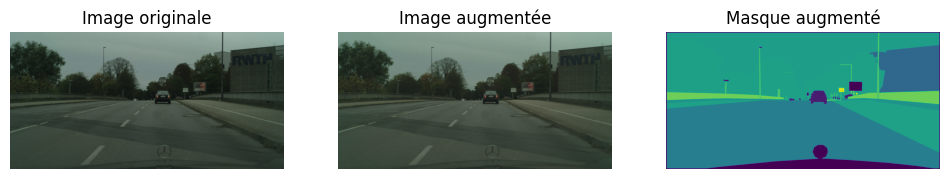

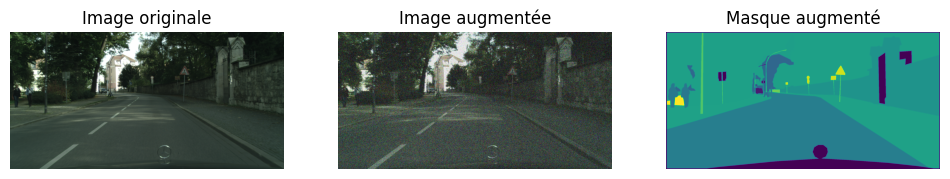

In [45]:
preprocess_func = preprocess_image_func(unet_mini)
augmented_test_generator = SegmentationDataGeneratorWithAugmentation(images_test, masks_test, batch_size, img_width, img_height, num_classes, preprocess_func)
for i in range(5):
    idx = np.random.randint(len(images_test))
    image_path = images_test[idx]
    mask_path = masks_test[idx]
    plot_image_and_augmented_image(augmented_test_generator, image_path, mask_path)

## 6.2 Entrainement des modèles avec data augmentation

Nous allons à présent entrainer nos modèles avec data augmentation:

In [48]:
data_aug_model_results = {}
for model in models:
    sModel = model.name
    start = time.time()
    data_aug_model_results[sModel] = {}
    print(f"Training the model {sModel} with data augmentation...")

    preprocess_func = preprocess_image_func(model)
    
    # Création des générateurs d'entraînement et de validation
    train_generator = SegmentationDataGeneratorWithAugmentation(images_train, masks_train, batch_size, img_width, img_height, num_classes, preprocess_func, training=True)
    val_generator = SegmentationDataGeneratorWithAugmentation(images_val, masks_val, batch_size, img_width, img_height, num_classes, preprocess_func)

    # Entraînement du modèle avec les données de validation
    model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        epochs=epochs,
        callbacks=[
            TqdmCallback(verbose=1),
            buildModelCheckpoint(f"data_aug_{sModel}"),
            buildEarlyStopping(),
            buildReduceLROnPlateau()
        ]
    )
    training_time = time.time() - start
    data_aug_model_results[sModel]["training time"] = training_time
    print(f"Model {sModel} trained in {training_time:.2f}s")

Training the model Unet_mini with data augmentation...


C:\Users\brice\AppData\Local\Temp\ipykernel_18324\705636211.py:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

C:\Users\brice\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.4527 - loss: 0.7159
Epoch 1: val_loss improved from inf to 0.58650, saving model to ../models/model_data_aug_Unet_mini_best_weights.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 694s 2s/step - iou_score: 0.4527 - loss: 0.7158 - val_iou_score: 0.5484 - val_loss: 0.5865 - learning_rate: 0.0010
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10


C:\Users\brice\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
C:\Users\brice\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
C:\Users\brice\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: iou_score,loss
  current = self.get_monitor_value(logs)
C:\Users\brice\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: iou_s

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.5012 - loss: 0.6423
Epoch 3: val_loss improved from 0.58650 to 0.54528, saving model to ../models/model_data_aug_Unet_mini_best_weights.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 618s 2s/step - iou_score: 0.5012 - loss: 0.6423 - val_iou_score: 0.5739 - val_loss: 0.5453 - learning_rate: 0.0010
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.5153 - loss: 0.6236
Epoch 5: val_loss did not improve from 0.54528
316/316 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - iou_score: 0.5153 - loss: 0.6236 - val_iou_score: 0.5534 - val_loss: 0.5853 - learning_rate: 0.0010
Epoch 6/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.5206 - loss: 0.6156
Epoch 7: val_loss improved from 0.54528 to 0.54437, sa

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.3338 - loss: 0.8952
Epoch 1: val_loss improved from inf to 0.54058, saving model to ../models/model_data_aug_VGG16_UNet_best_weights.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 878s 3s/step - iou_score: 0.3340 - loss: 0.8950 - val_iou_score: 0.5751 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_score: 0.4190 - loss: 0.7519
Epoch 3: val_loss improved from 0.54058 to 0.51422, saving model to ../models/model_data_aug_VGG16_UNet_best_weights.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 859s 3s/step - iou_score: 0.4190 - loss: 0.7518 - val_iou_score: 0.5963 - val_loss: 0.5142 - learning_rate: 0.0010
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - iou_score: 0.4502 - loss: 0.7280
Epoch 1: val_loss improved from inf to 0.46732, saving model to ../models/model_data_aug_Mobilenet_FPN_best_weights.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 1152s 4s/step - iou_score: 0.4503 - loss: 0.7279 - val_iou_score: 0.6339 - val_loss: 0.4673 - learning_rate: 0.0010
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - iou_score: 0.5025 - loss: 0.6434
Epoch 3: val_loss did not improve from 0.46732
316/316 ━━━━━━━━━━━━━━━━━━━━ 1123s 4s/step - iou_score: 0.5025 - loss: 0.6434 - val_iou_score: 0.6294 - val_loss: 0.4811 - learning_rate: 0.0010
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - iou_score: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - iou_score: 0.5126 - loss: 0.6284
Epoch 5: val_loss improved from 0.46732 t

## 6.3 Evaluation des modèles avec data augmentation

In [49]:
# Évaluation des modèles sur le jeu de test
for model in models:
    sModel = model.name
    print(f"Evaluating the model {sModel} with data augmentation on the test dataset")

    preprocess_func = preprocess_image_func(model)
    
    # Création des générateurs d'entraînement et de validation
    test_generator = SegmentationDataGeneratorWithAugmentation(images_test, masks_test, batch_size, img_width, img_height, num_classes, preprocess_func)
    
    loss, intersection_over_union = model.evaluate(test_generator)
    data_aug_model_results[sModel]["Loss"] = loss
    data_aug_model_results[sModel]["Intersection over union"] = intersection_over_union

Evaluating the model Unet_mini with data augmentation on the test dataset


C:\Users\brice\AppData\Local\Temp\ipykernel_18324\705636211.py:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - iou_score: 0.6065 - loss: 0.4921
Evaluating the model VGG16_UNet with data augmentation on the test dataset
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - iou_score: 0.6531 - loss: 0.4315
Evaluating the model Mobilenet_FPN with data augmentation on the test dataset
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - iou_score: 0.6982 - loss: 0.3755


Affichons les métriques avec data augmentation

In [50]:
data_aug_df = build_eval_results_dataframe(data_aug_model_results)
data_aug_df

,training time,Loss,Intersection over union
Unet_mini,3173.772613,0.493303,0.605036
VGG16_UNet,4327.571973,0.432733,0.652772
Mobilenet_FPN,5650.194974,0.377493,0.696149


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


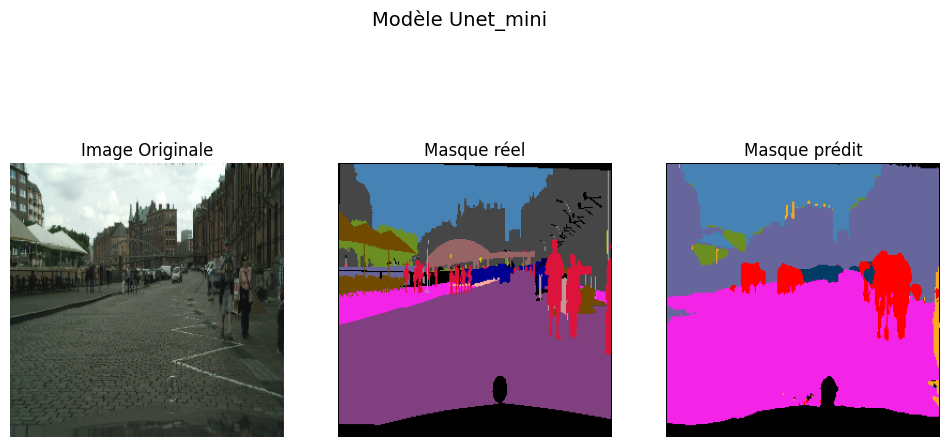

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


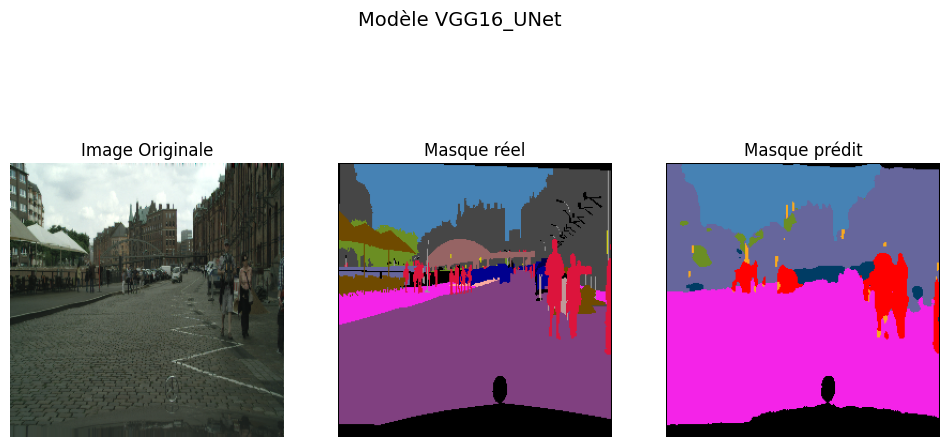

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


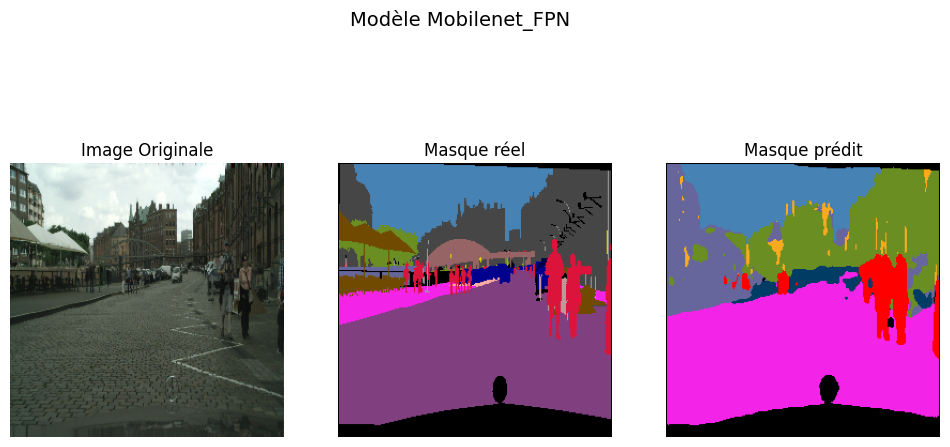

In [52]:
plot_predictions_for_random_image(models, images_test, masks_test, (img_width, img_height))